## Import Data

In [2]:
import os

In [3]:
if not os.path.isdir("../data"):
    

False


In [ ]:
if data not in data dir
    dl data from blob
if cant connect to blob
    print error message

In [ ]:
if 

In [17]:
#upload data from the blob
!wget https://storageforimageskaggle.blob.core.windows.net/somegarbage/garbageCollector.zip

--2019-03-07 15:20:59--  https://storageforimageskaggle.blob.core.windows.net/somegarbage/garbageCollector.zip
Resolving storageforimageskaggle.blob.core.windows.net... 52.239.177.36
Connecting to storageforimageskaggle.blob.core.windows.net|52.239.177.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42856812 (41M) [application/x-zip-compressed]
Saving to: ‘garbageCollector.zip’

garbageCollector.zi 100%[===================>]  40.87M  27.4MB/s    in 1.5s    

2019-03-07 15:21:01 (27.4 MB/s) - ‘garbageCollector.zip’ saved [42856812/42856812]



In [19]:
#unzip data
import zipfile
zip = zipfile.ZipFile('garbageCollector.zip')
zip.extractall('./')

In [73]:
!pwd
!ls garbageCollector

/data/home/adminadmin/notebooks
cardboard  glass  metal  paper	plastic  trash


In [61]:
#Install Pytorch and import libraries 
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
    
import torch
import torch.nn as nn
import torch.utils.data as utils
import torch.utils.data as td
from torch.autograd import Variable
from torchvision import datasets, models, transforms

print("Libraries imported - ready to use PyTorch", torch.__version__)


torch-1.0.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
Libraries imported - ready to use PyTorch 1.0.0


In [74]:
#Normalize images 

mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

transform = transforms.Compose([transforms.Resize((128,128)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])


In [75]:
#split data for train and test 

image_datasets ={}
data_dir = 'garbageCollector'

full_dataset = datasets.ImageFolder(data_dir, transform)

# Split into training (70% and testing (30%) datasets)
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

image_datasets['train'] = train_dataset
image_datasets['test'] = test_dataset
#Print length for each dataset
print(len (image_datasets['train']))
print(len(image_datasets['test']))

dataloaders = {}
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=8, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=8, shuffle=True, num_workers=4)
#test_loader = next(iter(train_loader))
#image_datasets['train']

1768
759


In [76]:
#show classes 
image_classes = full_dataset.classes
print(image_classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [77]:
# Dataset as iterator
dataiter = iter(train_loader)

In [78]:
# Get next batch
images, labels = dataiter.next()

In [79]:
images.shape

torch.Size([8, 3, 128, 128])

In [80]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# end imshow

First 4 labels ['metal', 'cardboard', 'plastic', 'glass', 'cardboard', 'cardboard', 'paper', 'paper']


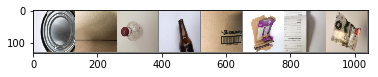

In [81]:
# Show images
n_batches = len(dataiter)
print(u"First 4 labels {}".format([image_classes[labels[j]] for j in range(8)]))

imshow(torchvision.utils.make_grid(images))

In [82]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [83]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 12 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A second convolutional layer takes 12 input channels, and generates 12 outputs
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        
        # A third convolutional layer takes 12 inputs and generates 24 outputs
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A drop layer deletes 20% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.2)
        
        # Our 128x128 image tensors will be pooled twice with a kernel size of 2. 128/2/2 is 32.
        # So our feature tensors are now 32 x 32, and we've generated 24 of them, so the array is 32x32x24
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after convolution 1 and pool
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after convolution 2 and pool
        x = F.relu(self.pool(self.conv2(x)))
        
        # Select some features to drop after the 3rd convolution to prevent overfitting
        x = F.relu(self.drop(self.conv3(x)))
        
        # Only drop the features if this is a training pass
        x = F.dropout(x, training=self.training)
        
        # Flatten
        x = x.view(-1, 32 * 32 * 24)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a softmax function 
        return F.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(image_classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.2)
  (fc): Linear(in_features=24576, out_features=6, bias=True)
)


In [84]:
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    return train_loss / len(train_loader.dataset)
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return test_loss
    
    
# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 5 epochs (in a real scenario, you'd likely use many more)
epochs = 50
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Epoch: 1
Training set [0/1768 (0%)] Loss: 1.771184
Training set [80/1768 (5%)] Loss: 1.352550
Training set [160/1768 (9%)] Loss: 1.782076
Training set [240/1768 (14%)] Loss: 1.622013
Training set [320/1768 (18%)] Loss: 1.732528
Training set [400/1768 (23%)] Loss: 1.826346
Training set [480/1768 (27%)] Loss: 2.116390
Training set [560/1768 (32%)] Loss: 1.261689
Training set [640/1768 (36%)] Loss: 1.601629
Training set [720/1768 (41%)] Loss: 1.813522
Training set [800/1768 (45%)] Loss: 1.549296
Training set [880/1768 (50%)] Loss: 1.403008
Training set [960/1768 (54%)] Loss: 0.976296
Training set [1040/1768 (59%)] Loss: 1.363037
Training set [1120/1768 (63%)] Loss: 1.489240
Training set [1200/1768 (68%)] Loss: 1.703896
Training set [1280/1768 (72%)] Loss: 1.258397
Training set [1360/1768 (77%)] Loss: 1.241681
Training set [1440/1768 (81%)] Loss: 1.487498
Training set [1520/1768 (86%)] Loss: 1.418598
Training set [1600/1768 (90%)] Loss: 1.651147
Training set [1680/1768 (95%)] Loss: 0.83572

Training set [800/1768 (45%)] Loss: 0.755912
Training set [880/1768 (50%)] Loss: 0.428564
Training set [960/1768 (54%)] Loss: 0.482819
Training set [1040/1768 (59%)] Loss: 0.767414
Training set [1120/1768 (63%)] Loss: 0.227530
Training set [1200/1768 (68%)] Loss: 0.273386
Training set [1280/1768 (72%)] Loss: 0.506174
Training set [1360/1768 (77%)] Loss: 0.451080
Training set [1440/1768 (81%)] Loss: 0.377849
Training set [1520/1768 (86%)] Loss: 0.678141
Training set [1600/1768 (90%)] Loss: 0.403197
Training set [1680/1768 (95%)] Loss: 0.415814
Training set [1760/1768 (100%)] Loss: 0.213187
Test set: Average loss: 0.1477, Accuracy: 469/759 (62%)

Epoch: 9
Training set [0/1768 (0%)] Loss: 0.452821
Training set [80/1768 (5%)] Loss: 0.460316
Training set [160/1768 (9%)] Loss: 0.360881
Training set [240/1768 (14%)] Loss: 0.322396
Training set [320/1768 (18%)] Loss: 0.217328
Training set [400/1768 (23%)] Loss: 0.419164
Training set [480/1768 (27%)] Loss: 0.343329
Training set [560/1768 (32%)]

Training set [1600/1768 (90%)] Loss: 0.037579
Training set [1680/1768 (95%)] Loss: 0.555229
Training set [1760/1768 (100%)] Loss: 0.011436
Test set: Average loss: 0.2040, Accuracy: 472/759 (62%)

Epoch: 16
Training set [0/1768 (0%)] Loss: 0.013536
Training set [80/1768 (5%)] Loss: 0.079689
Training set [160/1768 (9%)] Loss: 0.377420
Training set [240/1768 (14%)] Loss: 0.150339
Training set [320/1768 (18%)] Loss: 0.215035
Training set [400/1768 (23%)] Loss: 0.058936
Training set [480/1768 (27%)] Loss: 0.041982
Training set [560/1768 (32%)] Loss: 0.254180
Training set [640/1768 (36%)] Loss: 0.317197
Training set [720/1768 (41%)] Loss: 0.158013
Training set [800/1768 (45%)] Loss: 0.268562
Training set [880/1768 (50%)] Loss: 0.032895
Training set [960/1768 (54%)] Loss: 0.008096
Training set [1040/1768 (59%)] Loss: 0.130196
Training set [1120/1768 (63%)] Loss: 0.042259
Training set [1200/1768 (68%)] Loss: 0.115852
Training set [1280/1768 (72%)] Loss: 0.075359
Training set [1360/1768 (77%)] 

Training set [480/1768 (27%)] Loss: 0.372986
Training set [560/1768 (32%)] Loss: 0.009600
Training set [640/1768 (36%)] Loss: 0.009379
Training set [720/1768 (41%)] Loss: 0.015838
Training set [800/1768 (45%)] Loss: 0.013159
Training set [880/1768 (50%)] Loss: 0.298794
Training set [960/1768 (54%)] Loss: 0.221911
Training set [1040/1768 (59%)] Loss: 0.002387
Training set [1120/1768 (63%)] Loss: 0.006074
Training set [1200/1768 (68%)] Loss: 0.031913
Training set [1280/1768 (72%)] Loss: 0.010954
Training set [1360/1768 (77%)] Loss: 0.131694
Training set [1440/1768 (81%)] Loss: 0.226579
Training set [1520/1768 (86%)] Loss: 0.162699
Training set [1600/1768 (90%)] Loss: 0.009503
Training set [1680/1768 (95%)] Loss: 0.010949
Training set [1760/1768 (100%)] Loss: 0.013285
Test set: Average loss: 0.2300, Accuracy: 472/759 (62%)

Epoch: 24
Training set [0/1768 (0%)] Loss: 0.091834
Training set [80/1768 (5%)] Loss: 0.002643
Training set [160/1768 (9%)] Loss: 0.038739
Training set [240/1768 (14%)

Training set [1280/1768 (72%)] Loss: 0.007682
Training set [1360/1768 (77%)] Loss: 0.282920
Training set [1440/1768 (81%)] Loss: 0.033590
Training set [1520/1768 (86%)] Loss: 0.012439
Training set [1600/1768 (90%)] Loss: 0.000132
Training set [1680/1768 (95%)] Loss: 0.129830
Training set [1760/1768 (100%)] Loss: 0.010175
Test set: Average loss: 0.2778, Accuracy: 448/759 (59%)

Epoch: 31
Training set [0/1768 (0%)] Loss: 0.167963
Training set [80/1768 (5%)] Loss: 0.039527
Training set [160/1768 (9%)] Loss: 0.006498
Training set [240/1768 (14%)] Loss: 0.002138
Training set [320/1768 (18%)] Loss: 0.006742
Training set [400/1768 (23%)] Loss: 0.019216
Training set [480/1768 (27%)] Loss: 0.345093
Training set [560/1768 (32%)] Loss: 0.050993
Training set [640/1768 (36%)] Loss: 0.001730
Training set [720/1768 (41%)] Loss: 0.698964
Training set [800/1768 (45%)] Loss: 0.050284
Training set [880/1768 (50%)] Loss: 0.096239
Training set [960/1768 (54%)] Loss: 0.017312
Training set [1040/1768 (59%)] 

Training set [160/1768 (9%)] Loss: 0.001213
Training set [240/1768 (14%)] Loss: 0.000378
Training set [320/1768 (18%)] Loss: 0.002424
Training set [400/1768 (23%)] Loss: 0.039298
Training set [480/1768 (27%)] Loss: 0.000635
Training set [560/1768 (32%)] Loss: 0.029558
Training set [640/1768 (36%)] Loss: 0.022096
Training set [720/1768 (41%)] Loss: 0.020754
Training set [800/1768 (45%)] Loss: 0.054478
Training set [880/1768 (50%)] Loss: 0.001133
Training set [960/1768 (54%)] Loss: 0.057161
Training set [1040/1768 (59%)] Loss: 0.005518
Training set [1120/1768 (63%)] Loss: 0.001636
Training set [1200/1768 (68%)] Loss: 0.010662
Training set [1280/1768 (72%)] Loss: 0.175761
Training set [1360/1768 (77%)] Loss: 0.005344
Training set [1440/1768 (81%)] Loss: 0.975653
Training set [1520/1768 (86%)] Loss: 0.299411
Training set [1600/1768 (90%)] Loss: 0.401232
Training set [1680/1768 (95%)] Loss: 0.064853
Training set [1760/1768 (100%)] Loss: 0.022963
Test set: Average loss: 0.2678, Accuracy: 454

Training set [960/1768 (54%)] Loss: 0.001516
Training set [1040/1768 (59%)] Loss: 0.013546
Training set [1120/1768 (63%)] Loss: 0.000962
Training set [1200/1768 (68%)] Loss: 0.001416
Training set [1280/1768 (72%)] Loss: 0.011654
Training set [1360/1768 (77%)] Loss: 0.003447
Training set [1440/1768 (81%)] Loss: 0.022411
Training set [1520/1768 (86%)] Loss: 0.004115
Training set [1600/1768 (90%)] Loss: 0.009148
Training set [1680/1768 (95%)] Loss: 0.004982
Training set [1760/1768 (100%)] Loss: 0.069779
Test set: Average loss: 0.2718, Accuracy: 471/759 (62%)

Epoch: 46
Training set [0/1768 (0%)] Loss: 0.008262
Training set [80/1768 (5%)] Loss: 0.008774
Training set [160/1768 (9%)] Loss: 0.000928
Training set [240/1768 (14%)] Loss: 0.113516
Training set [320/1768 (18%)] Loss: 0.006810
Training set [400/1768 (23%)] Loss: 0.008126
Training set [480/1768 (27%)] Loss: 0.000022
Training set [560/1768 (32%)] Loss: 0.000077
Training set [640/1768 (36%)] Loss: 0.140507
Training set [720/1768 (41%)

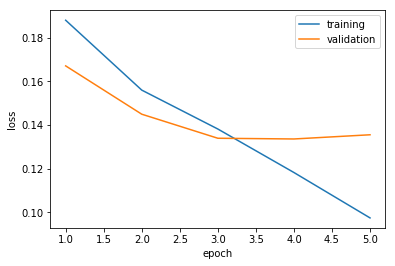

In [54]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [55]:
# Save the model weights
model_file = 'shape-classifier.pth'
torch.save(model.state_dict(), model_file)
print("Model saved.")

# Delete the existing model variable
del model

Model saved.


glass


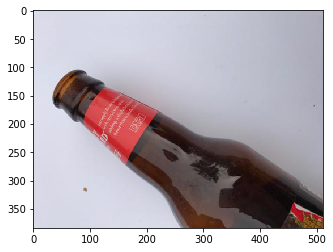

In [59]:
from PIL import Image

# Function to predict the class of an image
def predict_image(classifier, image_array):
   
    # Set the classifer model to evaluation mode
    classifier.eval()
        
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(image_classes[class_idx])
    return np.array(predicted_classes)


# Now let's try it with a new image
from random import randint

# Create a new model instance and load the weights
model = Net()
model.load_state_dict(torch.load(model_file))

# load image
img = np.array(Image.open('./garbageCollector/glass/glass20.jpg'));
plt.imshow(img)

# Create an array of (1) images to match the expected input format
image_array = img.reshape(1, img.shape[0], img.shape[1], img.shape[2]).astype('float32')

predicted_classes = predict_image(model, image_array)
print(predicted_classes[0])